# Pset on Inference

[Download notebook :fontawesome-solid-download:](../cps_inference.ipynb){: .md-button .md-button--primary download="cps_inference.ipynb"}

Goal of the problem set:

 - understand heteroskedasticity and clustered standard errors
 - familiarize yourself with `pandas`, grouping and formating
 - [TBD] learn about `numba` to accelerate your code for large data-sets
 
some useful references:

 - [OLS in python](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html)
 - [OLS with formulas](https://www.statsmodels.org/devel/example_formulas.html)
 - [pandas transorm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html)
 - [method chaining in pandas](https://tomaugspurger.github.io/method-chaining.html)
 - [progress bars](https://tqdm.github.io/)
 
We are going to reproduce an exercise similar to the example for the computation of standard error.  Start by downloading the CPS data from [here](http://cameron.econ.ucdavis.edu/research/cameron_miller_JHR_files%20to%20share.zip).  We first load the needed libraries, my solutions wich are hidden to you and the data.

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm


/Users/connorjones/mystuff/uchicago-31340-psets


In [2]:
data = pd.read_stata("/Users/connorjones/mystuff/uchicago-31340-psets/inf_data/CPS_2012_micro.dta")

Next generate a fictuous policy that you randomly assigned at the state times gender level. Run the regression and report standard errors given by R for one draw of the poilcy.

In [3]:
np.random.seed(60356548) # I fix the seed to make sure the draws are reproducible

# we draw the policy for each state
fpol = { k:np.random.uniform() > 0.5 for k in np.unique(data['statefip']) }
data['fp'] = data['statefip'].map(fpol)

data

,year,statefip,wtsupp,age,sex,yrseduc,wage_per_hour,lnwage,age2,fp
0,2012,Maine,569.43,44,Female,14.0,7.020000,1.948763,1936.0,True
1,2012,Maine,595.47,25,Male,16.0,2.117143,0.750067,625.0,True
2,2012,Maine,635.66,61,Female,16.0,16.672501,2.813761,3721.0,True
3,2012,Maine,635.66,62,Male,16.0,17.784000,2.878299,3844.0,True
4,2012,Maine,513.39,25,Female,12.0,9.633000,2.265195,625.0,True
...,...,...,...,...,...,...,...,...,...,...
65680,2012,Hawaii,282.87,24,Male,16.0,28.899000,3.363807,576.0,False
65681,2012,Hawaii,362.23,49,Male,18.0,18.525000,2.919121,2401.0,False
65682,2012,Hawaii,362.23,44,Female,20.0,18.525000,2.919121,1936.0,False
65683,2012,Hawaii,282.87,28,Male,18.0,24.082500,3.181485,784.0,False


!!! question "Question 1"
    As an exercise to get acquainted with pandas, here I would like for you to implement the following procedure:
    
1. compute the average wage in each state for each age decile (less than 20, betwen 20 and 30, ...)
2. [pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) the table with states in rows and age deciles in columns
3. using [pandas styling](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html), I want you to highlight the lowest wage in each age decile and I want you to format the average wage with onely 2 decimal points.


In [4]:
# Question 1 Functions

def round_10(num):
  r = np.ceil(num/10)*10
  return r;

def jones_question1(d):
    state_age_wage = d[["statefip", "age", "wage_per_hour"]]
    state_age_wage.age = state_age_wage.age.astype('float')
    state_age_wage.age = state_age_wage.age.apply(lambda x: round_10(x))
    state_age_wage = state_age_wage.groupby(['statefip', 'age']).agg({'wage_per_hour': 'mean'})
    state_age_wage = state_age_wage.reset_index()
    state_age_wage = state_age_wage.pivot(index="statefip", columns="age")
    state_age_wage = state_age_wage.wage_per_hour 
    state_age_wage = state_age_wage.style.highlight_min(color = 'yellow', 
                                                    axis = 0)
    state_age_wage = state_age_wage.format("{:.2f}")
    return state_age_wage;

jones_question1(data)


/opt/anaconda3/envs/econ31340-env/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


age,20.0,30.0,40.0,50.0,60.0,70.0
statefip,,,,,,
Alabama,8.20,11.33,15.50,19.39,17.38,15.21
Alaska,8.68,14.14,19.92,19.59,20.67,20.46
Arizona,9.76,11.97,16.55,18.63,18.46,21.30
Arkansas,6.52,12.47,14.95,17.36,16.13,14.26
California,8.52,12.82,18.98,20.55,21.52,21.34
Colorado,9.63,12.35,19.19,21.00,21.80,21.29
Connecticut,6.79,13.29,20.98,24.64,25.11,20.69
Delaware,6.05,12.61,17.07,19.70,17.89,20.10
District of Columbia,10.24,17.36,26.19,25.80,25.35,29.54


## A first regression

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('lnwage ~ fp', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnwage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.53
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           0.000687
Time:                        14:43:25   Log-Likelihood:                -62336.
No. Observations:               65685   AIC:                         1.247e+05
Df Residuals:                   65683   BIC:                         1.247e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6687      0.003    836.168      0.0

Note We do not control for state specific fixed effect as these would would be perfectly colinear with the policy.

Now this is surprising. We generated `fp` randomly across states, yet we find a **significant effect** of the policy on log wages. To gain understanding on what is happening we will generate our own data in a way where we control exactly what is happening.



## IID errors

Let's start by reassuring ourselves. Let's use an IID data generating process (DGP), run the regression and check the significance.

 1. compute the variance of `lnwage` in the sample. This is an estimate of our homoskedastic error.
 2. simulate a fictuous outcome `y2` simply equal to normal error with the estimated variance, and truly independent across individuals. Use `.assign(y2 = ...)` on the pandas dataFrame.
 3. regress this outcome `y2` on `fp`, our fictuous policy and collect the coefficient, also save if the coefficient is significant at 5%.
 4. run steps (2,3) 500 times.
 
!!! question "Question 2"
    Follow the previous steps and report how often we would consider teh coefficient on `fp`significant at 5%. You should find something close to 5% and you should feel better about the theory!


In [6]:
# Question 2 Functions

est_err = data.var()['lnwage']
rng = len(data['lnwage'])

def q2_helper(data):
    df = data.assign(y2 = np.random.normal(0, est_err, rng))
    results = smf.ols('y2 ~ fp', data=df).fit()
    return results.tvalues[1];

def jones_question2(data):
    ttest = [None] * 500
    ttest = list(map(lambda x: q2_helper(data), ttest))
    return ttest;

/opt/anaconda3/envs/econ31340-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


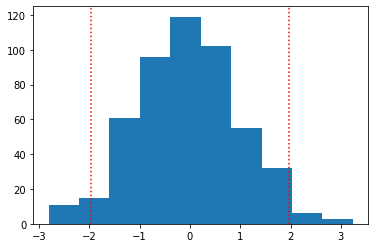

In [7]:
# I colled tstats across 500 replications and plot the histogram
tstats = jones_question2(data)
plt.hist(tstats)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

In [8]:
# I check that the distribution is outside of the 0.025 to 0.0975 quantiles of the normal with 
# probability close to 0.05
(np.abs(tstats)>1.96).mean()

0.048

## Back to using wages in data

We go back and we do the same exercise, only this time we redraw the policy in each replciations and regress the wages on it, and collect the t-stats. We then plot the histogram of the t-stats and compute the probability of rejecting the null that the coefficient on the policy is 0. 

!!! question "Question 3"
    Replicate 500 times the very first regression to recreate an histogram of t-stats similar to the following one. Compute the probability to reject the null of effect and comment on its value given the way you simulated the data (2 sentences max).

In [9]:
# Question 3 Functions

# Given that we are working with randomly assigned data we would expect not to reject the null
# and find many instances where the observed t value is greater than 1.96

def q3_helper(data):
    df = data
    fpol2 = { k:np.random.uniform() > 0.5 for k in np.unique(df['statefip']) }
    df['fp'] = df['statefip'].map(fpol2)
    results = smf.ols('lnwage ~ fp', data=df).fit()
    return results.tvalues[1];

def jones_question3(data):
    ttest2 = [None] * 500
    ttest2 = list(map(lambda x: q3_helper(data), ttest2))
    return ttest2;

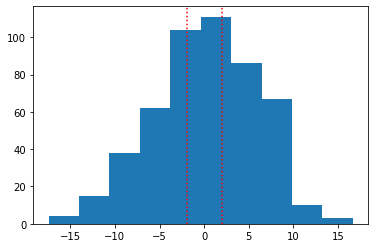

In [10]:
tstats = jones_question3(data)
plt.hist(tstats)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

In [11]:
(np.abs(tstats)>1.96).mean()

0.726

## Heteroskedastic errors

Now we want to simulate heteroskedastic robust standard errors which requires us to use some co-variates. We then want to repeat the previous procedure, but we are going to use a different code for simulation and a new test for the significance. `statsmodels` can do that for you using the `cov_type` argument of the `fit` method.

We want to check this by simulating from a model with heteroskedesatic errors. To do so we are going to use linear model for the variance:

$$ y_{i} = 0 + s(x_i) \cdot \epsilon_i$$

We are going to use a linear specification for $s^2(x_i)$. 

 1. run the following regression `lnwage ~ yrseduc + age + age^2` to get the $m(x_i) = x_i' \beta$ where the $x_i$ are education, age and age squared. 
 2. extract the residuals $\hat{u}_i$ from the previous regression. Then regress $\hat{u}^2_i$ on `yrseduc + age + age^2`, to get the $s^2(x_i) = x_i' \gamma$ model.
 2. using $s^2(x_i) = x_i' \gamma$, construct $ y_{i} = 0 + s(x_i) \cdot \epsilon_i$ where $\epsilon_i$ is drawn iid Normal(0,1).
 5. replicate this 500 times, evaluate the significance of `fp` using heteroskedastic roduct inference by calling `.fit(cov_type='HC0')`, also save without using the robust errors.

!!! question "Question 4"
    Follow the steps and report the distributions of t-stats, as well as the rejection rates for each of the two variance specifications.

In [12]:
# Question 4 Functions

def q4_helper(data):
    df = data
    df.age = df.age.astype(float) # need to change type for regression
    results = smf.ols('lnwage ~ yrseduc + age + age2', data=df).fit()
    df = df.assign(u2 = results.resid**2)
    results2 = smf.ols('u2 ~ yrseduc + age + age2', data=df).fit()
    gammas = results2.params
    df = df.assign(s2=lambda x: x.yrseduc*gammas[1] + x.age*gammas[2] + x.age2*gammas[3])
    df = df.assign(s=lambda x: x.s2**(1/2))
    length = len(df.s)
    df = df.assign(y_i=lambda x: x.s*np.random.normal(0,1,length))
    results3 = smf.ols('y_i ~ fp', data=df).fit()
    results4 = smf.ols('y_i ~ fp', data=df).fit(cov_type='HC0')
    return [results3.tvalues[1],results4.tvalues[1]];

def jones_question4(data, R):
    ttest3 = [None] * R
    ttest3 = list(map(lambda x: q4_helper(data), ttest3))
    ttest3_df = pd.DataFrame(ttest3, columns=['Homoskedastic','Heteroskedastic'])
    return ttest3_df;

In [13]:
tstats = jones_question4(data,R=500)
tstats

,Homoskedastic,Heteroskedastic
0,1.090917,1.092212
1,1.240184,1.239841
2,0.438856,0.437995
3,-0.956978,-0.954632
4,-0.492189,-0.492644
...,...,...
495,-0.198210,-0.198105
496,0.088301,0.088467
497,-0.251674,-0.251578
498,-1.538501,-1.539751


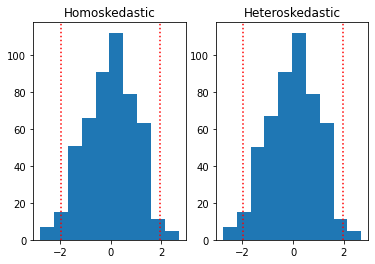

In [14]:
# tstats = jones_question4(data,R=500)
plt.subplot(1,2,1)
plt.hist(tstats.Homoskedastic)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Homoskedastic')

plt.subplot(1,2,2)
plt.hist(tstats.Heteroskedastic)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Heteroskedastic')

plt.show()

## State clustered errors

We are going to simulate corrolated error within state. To do so we continue to draw independent error terms $u_i$ but we add to them a common draw at the state level. In practice you can do that by doing similar to drawing the `fp`. We then create the outcome as 

$$y_{ig} = (1-\rho) u_i + \rho v_g $$

Here is a way of doing this: 

!!! question "Question 5"
    First, explain the `groupby` expression. Next find another way of doing line 2 and 3, but try to minize the number of characters (see [python golfing](https://www.geeksforgeeks.org/code-golfing-in-python/) or more generaly [wikipedia](https://en.wikipedia.org/wiki/Code_golf)).

In [15]:
# Question 5 Functions

# The group by function takes the data frame and creates a map object based on the group
# that a function, in this case transform, can be applied to. 

rho=0.5

# 30 fewer characters!
data['u'] = np.random.normal(0,1,len(data))
for x in data.statefip: 
    data['v'] = rho*np.random.normal() + (1-rho)*data['u']

data

,year,statefip,wtsupp,age,sex,yrseduc,wage_per_hour,lnwage,age2,fp,u,v
0,2012,Maine,569.43,44.0,Female,14.0,7.020000,1.948763,1936.0,True,-1.308531,-0.969108
1,2012,Maine,595.47,25.0,Male,16.0,2.117143,0.750067,625.0,True,-0.003338,-0.316512
2,2012,Maine,635.66,61.0,Female,16.0,16.672501,2.813761,3721.0,True,-0.123518,-0.376601
3,2012,Maine,635.66,62.0,Male,16.0,17.784000,2.878299,3844.0,True,-0.774372,-0.702029
4,2012,Maine,513.39,25.0,Female,12.0,9.633000,2.265195,625.0,True,-0.514829,-0.572257
...,...,...,...,...,...,...,...,...,...,...,...,...
65680,2012,Hawaii,282.87,24.0,Male,16.0,28.899000,3.363807,576.0,False,1.353983,0.362149
65681,2012,Hawaii,362.23,49.0,Male,18.0,18.525000,2.919121,2401.0,False,-0.073374,-0.351530
65682,2012,Hawaii,362.23,44.0,Female,20.0,18.525000,2.919121,1936.0,False,-2.485267,-1.557476
65683,2012,Hawaii,282.87,28.0,Male,18.0,24.082500,3.181485,784.0,False,0.341856,-0.143914


Before we get started estimating the effect of the policy, let's write a function that computes the within state correlation in the error term. 

To that end draw 500 pairs of people where the 2 people in a pair belong to the same state. This gives you 2 vector of length 500. Compute the correlation between these 2 vectors. Use the `sample` and `query` methods of `pandas`. Similarly construct a placebo function that just takes random pairs of workers without imposing that they come from the same state.

!!! question "Question 6"
    Write your own version of the `tibo_pair_cor` and `tibo_cor_placebo` functions, see what my version delivers:

In [16]:
# Question 6 Functions

def pair_cor_helper(data):
    nstates = len(np.unique(data['statefip']))
    state = np.unique(data['statefip'])[np.random.randint(nstates)]
    spair = data[data.statefip == np.unique(data['statefip'])[np.random.randint(nstates)]].sample(2)['v']
    return [spair.values[0], spair.values[1], state];

def jones_pair_cor(data):
    spair_vector = [None] * 500
    spair_vector = list(map(lambda x: pair_cor_helper(data), spair_vector))
    spair_df = pd.DataFrame(spair_vector, columns=['Person1', 'Person2', 'State'])
    corr = spair_df['Person1'].corr(spair_df['Person2'])
    return corr;

def cor_placebo_helper(data):
    rpair = data.sample(2)['v']
    return [rpair.values[0], rpair.values[1]];

def jones_pair_cor_placebo(data):
    rpair_vector = [None] * 500
    rpair_vector = list(map(lambda x: cor_placebo_helper(data), rpair_vector))
    rpair_df = pd.DataFrame(rpair_vector, columns=['Person1', 'Person2'])
    corr2 = rpair_df['Person1'].corr(rpair_df['Person2'])
    return corr2;

In [17]:
rho=0.5
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

print(jones_pair_cor(data))
print(jones_pair_cor_placebo(data))

rho=0.8
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

print(jones_pair_cor(data))
print(jones_pair_cor_placebo(data))

0.5236191821707333
-0.00873917452039787
0.9194825495044269
-0.02399843250498093


We are then going to replicate the data construction 500 times.

!!! question "Question 7"
    For $\rho=0.2,0.5,0.8$ run 500 replications and report the proportion at each value of $\rho$ for which the coefficient on $\text{fp}$ is significant at 5%. Report the results for three different regression using regular `fit`, using `cov_type='HC0'` and using `cov_type='cluster'`.

In [18]:
# Question 7 Functions

def q7_helper(data, rho):
    df = data
    df['u'] = np.random.normal(size=len(df))
    df['v'] = df.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))
    data['y'] =  data.v
    
    results = smf.ols('y ~ fp', data=data).fit()
    results2 = smf.ols('y ~ fp', data=data).fit(cov_type='HC0')
    results3 = smf.ols('y ~ fp', data=df).fit(cov_type='cluster',cov_kwds={"groups":data['statefip']})
    return [results.tvalues[1], results2.tvalues[1], results3.tvalues[1]];

def tvalues500(data, rho):
    tv500 = [None] * 500
    tv500 = list(map(lambda x: q7_helper(data, rho), tv500))
    tv500_df = pd.DataFrame(tv500, columns=['NoCluster', 'Hc0', 'Clustered'])

    return tv500_df;

In [19]:
rho2 = tvalues500(data, 0.2)

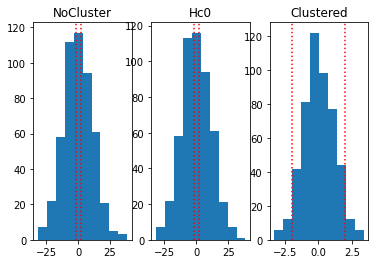

In [20]:

plt.subplot(1,3,1)
plt.hist(rho2.NoCluster)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('NoCluster')

plt.subplot(1,3,2)
plt.hist(rho2.Hc0)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Hc0')

plt.subplot(1,3,3)
plt.hist(rho2.Clustered)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Clustered')

plt.show()

In [21]:
(np.abs(rho2.Clustered)>1.96).mean()

0.08

In [22]:
rho5 = tvalues500(data, 0.5)

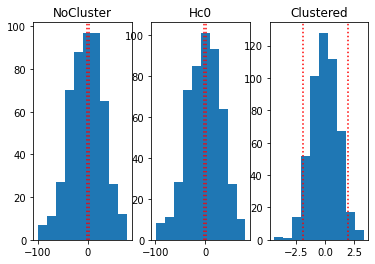

In [23]:
plt.subplot(1,3,1)
plt.hist(rho5.NoCluster)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('NoCluster')

plt.subplot(1,3,2)
plt.hist(rho5.Hc0)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Hc0')

plt.subplot(1,3,3)
plt.hist(rho5.Clustered)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Clustered')

plt.show()

In [24]:
(np.abs(rho5.Clustered)>1.96).mean()

0.084

In [25]:
rho8 = tvalues500(data, 0.8)

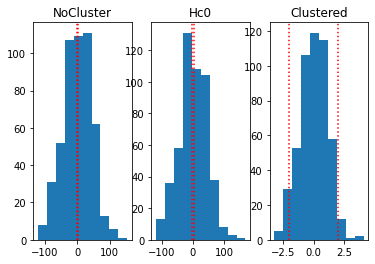

In [26]:
plt.subplot(1,3,1)
plt.hist(rho8.NoCluster)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('NoCluster')

plt.subplot(1,3,2)
plt.hist(rho8.Hc0)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Hc0')

plt.subplot(1,3,3)
plt.hist(rho8.Clustered)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Clustered')

plt.show()

In [27]:
(np.abs(rho8.Clustered)>1.96).mean()

0.07